In [1]:
import mitsuba as mi
import drjit as dr

mi.set_variant('cuda_ad_rgb')

scene = mi.load_file('../scenes/editing-a-scene/cbox.xml')

In [2]:
# Camera origin in world space
cam_origin = mi.Point3f(0, 1, 3)

# Camera view direction in world space
cam_dir = dr.normalize(mi.Vector3f(0, -0.5, -1))

# Camera width and height in world space
cam_width  = 2.0
cam_height = 2.0

# Image pixel resolution
image_res = [256, 256]

In [3]:
# Construct a grid of 2D coordinates
x, y = dr.meshgrid(
    dr.linspace(mi.Float, -cam_width  / 2,   cam_width / 2, image_res[0]),
    dr.linspace(mi.Float, -cam_height / 2,  cam_height / 2, image_res[1])
)

# Ray origin in local coordinates
ray_origin_local = mi.Vector3f(x, y, 0)

# Ray origin in world coordinates
ray_origin = mi.Frame3f(cam_dir).to_world(ray_origin_local) + cam_origin

In [4]:
ray = mi.Ray3f(o=ray_origin, d=cam_dir)

In [5]:
si = scene.ray_intersect(ray)

In [6]:
ambient_range = 0.75
ambient_ray_count = 256

In [7]:
# Initialize the random number generator
rng = mi.PCG32(size=dr.prod(image_res))

### Ambient Occlusion

In [11]:
# loop iteration counter
i = mi.UInt32(0)

# accumulated result
result = mi.Float(0)

# init the loop state (listing all variables that are modified inside the loop)
loop = mi.Loop(name="", state=lambda: (rng, i, result))

while loop(si.is_valid() & (i < ambient_ray_count)):
    # 1. draw some samples
    sample_1, sample_2 = rng.next_float32(), rng.next_float32()

    # 2. compute directions on the hemisphere using the random numbers
    # wo_local = mi.warp.square_to_uniform_hemisphere([sample_1, sample_2])

    # Alternatively, we could also sample a cosine-weighted hemisphere
    wo_local = mi.warp.square_to_cosine_hemisphere([sample_1, sample_2])

    # 3. transform the smaled directions to world space
    wo_world = si.sh_frame.to_world(wo_local)

    # 4. Spawn a new ray starting at the surface interactions
    ray_2 = si.spawn_ray(wo_world)

    # 5. set max intersection distance to only account for the close-by geometry
    ray_2.maxt = ambient_range

    # 6.accumulate a value of 1 if not occluded (0 otherwise)
    result[~scene.ray_test(ray_2)] += 1.0

    # 7. increase loop iteration counter
    i += 1

# divide the result by the number of samples
result = result / ambient_ray_count

The algorithm above accumulated ambient occlusion samples in a 1-dimensional array result. To work with this result as an image, we construct a TensorXf using the image resolution specified earlier.

In [13]:
image = mi.TensorXf(result, shape=image_res)

(-0.5, 255.5, 255.5, -0.5)

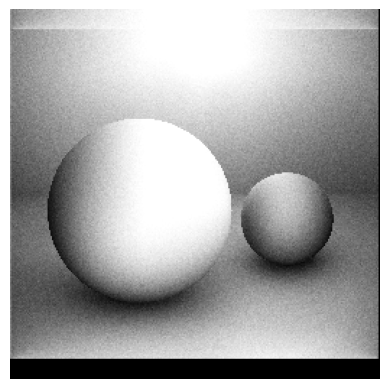

In [14]:
import matplotlib.pyplot as plt

plt.imshow(image, cmap='gray'); plt.axis('off')